# K-Nearest Neighbors from Scratch

<img src='pic/knn.jpg' width=400>

KNN Stands for K-Nearest Neighbors. It's a **non-parametric, lazy learning algorithm** that makes predictions based on **feature similarity**: how close you are to your nearest neighbors. It assumes that **similar items will exist in close proximity**. 

It's mostly used as a **classifier**, where the class of the target variable is defined through **majority voting**. It can also be used as a **regressor**, where the value of the target variable is calculated through **averaging**.

In this notebook, we will first implement KNN classifier and then entend that classifier to become KNN regressor. We will also load datasets provided in sklearn to compare the results with the standard sklearn model.

---
## What is the main characteristic of KNN algorithm?

**Distances** between vectors are calculated to define what's so-called **nearest neighbors**. From these "nearest negihbors", we can derive classes (classification) or values (regression) for the unlabeled data.

There are mainly two types of distances:

1. **`Euclidean distance`**.

$$ \sqrt{\sum \limits_{i=i}^k (x_{i} - y_{i})^2}$$


2. **`Manhattan distance`**.

$$ \lvert\sum \limits_{i=i}^k (x_{i} - y_{i})^2\rvert$$


The two distances above can both be discribed by a single **Minkowski** metric, and a parameter **p**.

$$ (\sum \limits_{i=1}^k (\lvert x_{i} - y_{i} \rvert)^p)^{1/p} $$

When **p = 1**, the Minkowski metric is the same as the Manhattan distance.

When **p = 2**, the Minkowski metric is the same as the Euclidean distance.

In sklearn, the default metric is minkowski and the p = 2. Thus, the default distance function for KNN classifier is Euclidean distance. If you want to change it to another type of distance functionm simply tune the value of p. For more information about the type of distance (the relationship of **metric** and **p**), please refer to the [sklearn's documentation about **DistanceMetric**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric).
```python
KNeighborsClassifier(n_neighbors=5,
    p=2,
    metric='minkowski')
```
---
## Uniform KNN vs. Weighted KNN

By default, KNN treats all the nearest neighbors equally. However, this can cause some problems. Consider the following example.

<img src='pic/weighted.jpg' width=300>

If we want to **assign a color** to the undefined green datapoint, with **k = 3** the green circle will be assigned to the color **red**. With **k = 5**, the green circle will be assigned to the color **blue**. You might notice that the two red datapoints are much closer to the undefined green datapoint. Thus, intuitively this green datapoint should be assigned to be **red**. This is when the **weighted KNN** comes into play. 

Let's say the distance between the undefined green datapoints and its five nearest neighbors are 0.1(red), 0.2(red), 0.5(blue), 1.0(blue), 1.2(blue). With Uniform KNN, these distances will not be considered and thus five datapoints will be treated the same.

However, the weights of the weighted KNN are obtained by taking the sum of inversion of distances.

Thus, the weighted distances to color blue will be

$$ (\frac{1}{0.5} + \frac{1}{1} + \frac{1}{1.2}) = 3.83 $$

The weighted distances to color red will be

$$ (\frac{1}{0.1} + \frac{1}{0.2}) = 15 $$

Clearly, with the weighted KNN, the undefined green datapoint should be classified as the color **red**. 

---
## How to decide the number of neighbors?

In the example above, besides the choice between uniform KNN and weighted KNN, we can see that the number of neighbors is the core deciding factor for the outcome. We should come up with some rule of thumbs when implementing this algorithm so that the results will not be affected by bias/variance due to sampling.

Research has shown that **there is no optimal number of neighbors suits all kind of datasets**. When k is set to a small value, noise within the dataset will have a higher influence on the result; when k is set to a high value, it will be computationally expensive to compute the result and might be hard to interpret practically.

Generally speaking, **small number of neighbors** are more flexible fit, which will have **low bias but high variance**, and a **high number of neighbors** will ha ve a smoother decision boundary, which will cause a **lower variance but higher bias**.

As a rule of thumb, you should choose an odd number to be the number of neighbors when the classes is even. Thus, you will not encounter the case when two classes are equally near to the undefined variable. 

---

## K-Nearest Neighbor Classifier

In [148]:
import numpy as np
from collections import Counter
from sklearn import datasets
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [135]:
# Generate data for classification
cancer = datasets.load_breast_cancer() # Load the classic breast cancer dataset
X, y = cancer.data, cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [114]:
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

Check out the [sklearn documentation](https://scikit-learn.org/stable/datasets/index.html#iris-dataset) about the breast cancer dataset if you are interested in more detail.

### Modeling

In [115]:
def euclidean_distance(x1, x2):
    """
    Simple Euclidean distance is implemented
    """
    return np.sqrt(np.sum((x1-x2)**2))

In [116]:
class KNN_classifier:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X, y):
        """
        In KNN, this fit method doesn't actually involve any training step.
        All it does is to store the training sample so that you can use them later.
        """
        # Lazy algorithm
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        """
        Main predict method that handles multiple samples. 
        """
        predicted_labels = [self._predict(x) for x in X]
        return np.array(predicted_labels)
        
    def _predict(self, x):
        """
        Helper method for one-sample prediction.
        """
        # Compute distances
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        
        # Get k nearest samples, labels
        k_indices = np.argsort(distances)[:self.k] # Default to ascending
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        # majority vote, assgined to most common class label
        most_common = Counter(k_nearest_labels).most_common(1) # return list of tuples [(a,b)] (values, # of appearences)
        return most_common[0][0]

In [136]:
# Custom KNN model
clf = KNN_classifier(k=5)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(f"The accuracy of the custom KNN model: {100*(predictions == y_test).sum() / len(y_test):.2f}%")

The accuracy of the custom KNN model: 93.86%


In [137]:
# Sklearn's KNN model
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(f"The accuracy of sklearn's KNN model: {100*(predictions == y_test).sum() / len(y_test):.2f}%")

The accuracy of sklearn's KNN model: 93.86%


Let's take a look at the decision boundary.

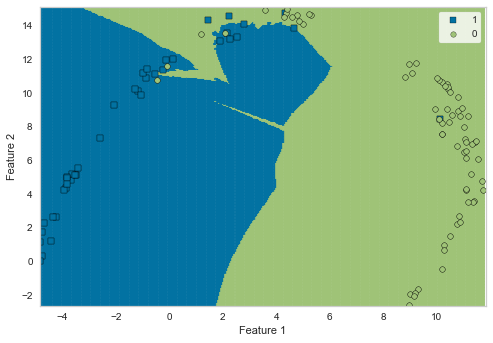

In [149]:
import umap # dimesionality reduction
fitter = umap.UMAP()
X_train_umap = fitter.fit_transform(X_train)
X_test_umap = fitter.transform(X_test)

from yellowbrick.contrib.classifier import DecisionViz # visualization
viz = DecisionViz(
    KNeighborsClassifier(n_neighbors=5), title="Nearest Neighbors",
    features=['Feature 1', 'Feature 2'], classes=['1', '0']
)
viz.fit(X_train_umap, y_train)
viz.draw(X_test_umap, y_test)
viz.show()

We can see that our custom KNN_classifier derives the same results as the sklearn's KNN classifier.

---
## K-Nearest Neighbor Regressor

What if we want to implement KNN as a regressor? One simple implementation of KNN regressor is replace the technique of majority voting with **the average of numerical target of the K nearest neighbors**. Another approach is to use an inverse distance weighted average of the K nearest neighbors.

In [127]:
# Generate data for classification
diabetes = datasets.load_diabetes() # Load the classic breast cancer dataset
X, y = diabetes.data, diabetes.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [128]:
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

Check out the [sklearn documentation](https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset) about the diabetes  dataset if you are interested in more detail.

### Modeling

In [129]:
class KNN_regressor:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X, y):
        """
        In KNN, this fit method doesn't actually involve any training step.
        All it does is to store the training sample so that you can use them later.
        """
        # Lazy algorithm
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        """
        Main predict method that handles multiple samples. 
        """
        predicted_labels = [self._predict(x) for x in X]
        return np.array(predicted_labels)
        
    def _predict(self, x):
        """
        Helper method for one-sample prediction.
        """
        # Compute distances
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        
        # Get k nearest samples, labels
        k_indices = np.argsort(distances)[:self.k] # Default to ascending
        k_nearest_values = [self.y_train[i] for i in k_indices]
        
        # averaging the values of the nearest neighbors
        avgs = np.mean(k_nearest_values)
        
        return avgs

In [132]:
# Custom KNN model
from sklearn.metrics import mean_squared_error
clf = KNN_regressor(k=5)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(f"The MSE of the custom KNN model: {mean_squared_error(y_test, predictions)}")

The MSE of the custom KNN model: 3589.1703370786513


In [133]:
# Sklearn's KNN model
from sklearn.neighbors import KNeighborsRegressor
clf = KNeighborsRegressor(n_neighbors=5)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(f"The MSE of sklearn's KNN model: {mean_squared_error(y_test, predictions)}")

The MSE of sklearn's KNN model: 3589.1703370786513


---
## KNN Improvement: KD-Tree, Ball-Tree

One drawback for the custom version of KNN is that it has to remember all the training data and calculates all the distances between the datapoint and all the others. When the number of datapoints increases to a very large number, this can be computationally expensive. Thus, in sklearn you can implement **KD Tree** and **Ball Tree** structure as an improvement for fast indexing.

The choice of neighbors search in sklearn is controlled by the parameter **algorithm**.

```python
KNeighborsClassifier(algorithm='kd_tree')
```

Valid choice of parameter **algorithm**:
* **`brute`**:  will use a brute-force search (calculate all the paiw-wise distance).
* **`kd_tree`**:  will use the **KD Tree structure**.
* **`ball_tree`**:  will use the **Ball Tree strucute**.
* **`auto`**:  will attempt to decide the most appropriate algorithm based on the values passed to fit method.

### Query Time Comparison

**`N`**: number of samples,       
**`D`**: number of features

* **Brute Force**: $O[DN]$

* **KD Tree**: 
    - D <=20 : $O[Dlog(N)]$
    - D > 20 : $O[DN]$

* **Ball Tree**: $O[Dlog(N)]$


### Leaf Size
There's one more parameter in sklearn's KNN model called leaf_size. 

```python
KNeighborsClassifier(leaf_size=30)
```

This leaf_size parameter is not referenced in brute force method, thus not in our customed KNN inplementation. What this parameter does is that it controls the leaf size of the KD Ball and Tree Ball structure.

For small smaple sizes (N < 30), brute force search can be more efficient than a tree-based query. Thus, when **N < leaf_size** (default value 30), the algorithm will be internally switched to brute force. 

You can also change this leaf_size value, and the parameter chocie has many effects.

1. A **higher leaf_size value** leads to **lower number of nodes**, thus **faster tree constuction time**.

2. **Both a large of a small leaf_size value lead to sub-optimal query time**. The optimal leaf_size value for fastest query time is the default value 30.

3. The higher the leaf_size value, the lower the memory required to store the tree structure.


For more detail about these nearest neighbor algorithms, check out the well-written [sklearn documentation about Nearest Neighbor Algorithms](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbor-algorithms).

---
## Pros and Cons for KNN

### Pros

* No assumptions needed for the distribution of the data. Practical choice in the real world and useful for nonlinear data.

* Easy to interpret and understand even for non-technical worker.

* Useful for both calssification and regression problems.

### Cons

* As it stores all the training data, it can be computationally expensive and has high memory requirement.

* When number of neighbors is set to a large number, the prediction can be slow.

* Can be sensitive irrelevant features and the curse of dimensionality.

* Train_Test_Split process can have significant impact on the result. 

---
**Resource**: 

[K-Nearest Neighbors – the Laziest Machine Learning Technique by KDnuggets](https://www.kdnuggets.com/2017/09/rapidminer-k-nearest-neighbors-laziest-machine-learning-technique.html)

[KNN Classification using Scikit-learn by DataCamp Avinash Navlani](https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn)

[Machine Learning Basics with the K-Nearest Neighbors Algorithm by Onel Harrison](https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761)

[A Quick Introduction to K-Nearest Neighbors Algorithm](https://blog.usejournal.com/a-quick-introduction-to-k-nearest-neighbors-algorithm-62214cea29c7)

[sklearn Documentation for DistanceMetric](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric)

[sklearn Documentation for KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

[sklearn Documentation for Nearest Neighbor Algorithms](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbor-algorithms)